# 2013-2018 Gun Violence in America: 
## Did a New Presidential Term Bring More Violence?

America loves guns but, according to many, it comes at a price. Bloomberg recently [reported that](https://www.bloomberg.com/news/articles/2022-05-25/how-many-guns-in-the-us-buying-spree-bolsters-lead-as-most-armed-country?leadSource=uverify%20wall) there are 120.5 guns per 100 Americans, totalling 3.93 Million firearms (2022). With more guns seems to come more violence as the United States as the United States hosts the [most mass shootings in the world](https://worldpopulationreview.com/country-rankings/mass-shootings-by-country). 

We know that the 2020 pandemic brought an onslaught of firearms sales in the United States. What we would like to know is whether or not the shift from President Barack Obama's terms to President Donald Trump's triggered more violence in 2016, which was a rather tumultuous election year. As such, we will review 2013-2018 data from [Gun Violence Archive](https://www.gunviolencearchive.org/), scraped by James Qo and [made available on Github](https://github.com/ainems/gun-violence-data).

## Hypothesis

Gun violence in the United States increased by at least 5% during the 2016 election year.

### Limitations

The data in question has the following limitations:
* only 279 incidents recorded in 2013
* two removed incidents: Las Vegas mass shooting incident and incident 1081885 - scraping errors
* missing address for 16k entries
* data was flattened into single record per incident by ingesting python dictionaries to certain fields
* states are listed in full form, not abbreviations (tricky for heatmaps)

### Additional Source

Our additional data source is from [World Population Review](https://worldpopulationreview.com/states/state-abbreviations), which administers state abbreviations per fully listed state. We plan to add abbreviations to our main source with this source

In [1]:
## import relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.express as px
from scipy.stats import chisquare
%matplotlib inline

## read in data

data = pd.read_csv('stage3.csv')
states = pd.read_csv('statedata.csv')
data.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


We need to make sure that all incident id's are unique records. We will do this by getting the shape of the data, then the shape of all unique incident id's.

In [2]:
## 29 columns and 249677 records

print(data.shape)

## check that all incident id's are unique

print(data['incident_id'].unique().shape[0])

(239677, 29)
239677


We passed the check! Now we should review the data types in our dataset.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239677 entries, 0 to 239676
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   incident_id                  239677 non-null  int64  
 1   date                         239677 non-null  object 
 2   state                        239677 non-null  object 
 3   city_or_county               239677 non-null  object 
 4   address                      223180 non-null  object 
 5   n_killed                     239677 non-null  int64  
 6   n_injured                    239677 non-null  int64  
 7   incident_url                 239677 non-null  object 
 8   source_url                   239209 non-null  object 
 9   incident_url_fields_missing  239677 non-null  bool   
 10  congressional_district       227733 non-null  float64
 11  gun_stolen                   140179 non-null  object 
 12  gun_type                     140226 non-null  object 
 13 

## Cleaning Data

It appears that `date` is not a datetime object - it is yet a mere string object. Additionally we have found that states are listed in full rather than by abbreviation. If we wish to generate heatmaps we will want state abbreviations.

Onto converting and merging our data sources!

### Date Conversions

In [4]:
## convert date to datetime[64]
data['date'] = pd.to_datetime(data['date'])

In [5]:
print(data['date'].min())
print(data['date'].max())

2013-01-01 00:00:00
2018-03-31 00:00:00


### Merging In State Abbreviations

We will do a simple dataframe merge to bring state abbreviations into our main dataset.

In [6]:
## append state abbreviations to data source
data_states = pd.merge(left = data, right = states, how='left', 
                       left_on='state',right_on='state')
data_states.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district,abbrev,code
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN,Pa.,PA
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0,Calif.,CA
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0,Ohio,OH
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0,Colo.,CO
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0,N.C.,NC


In [7]:
## make sure all records have state abbreviation
data_states.notna().sum()

incident_id                    239677
date                           239677
state                          239677
city_or_county                 239677
address                        223180
n_killed                       239677
n_injured                      239677
incident_url                   239677
source_url                     239209
incident_url_fields_missing    239677
congressional_district         227733
gun_stolen                     140179
gun_type                       140226
incident_characteristics       239351
latitude                       231754
location_description            42089
longitude                      231754
n_guns_involved                140226
notes                          158660
participant_age                147379
participant_age_group          197558
participant_gender             203315
participant_name               117424
participant_relationship        15774
participant_status             212051
participant_type               214814
sources     

### Restrict Columns

Let's restrict the columns to what we will use for this analysis. Essentially we want to understand events by year, so we don't need details about participants.

In [8]:
## restrict columns in dataset
data_states = data_states[['incident_id','date','code',
                           'city_or_county','n_killed','n_injured']].copy()

### Restrict Dates

Since there are only 279 records for 2013 and 2018 records run only through March, we will restrict our dataset to incidents occurring 2014-2017.

In [9]:
## bool to filter dates
bool_date = (data_states['date'] >= '2014-01-01') & (data_states['date'] < '2018-01-01')

## new and improved dataset using bool
data_states = data_states[bool_date].copy()
data_states.head()

,incident_id,date,code,city_or_county,n_killed,n_injured
278,95289,2014-01-01,MI,Muskegon,0,0
279,92401,2014-01-01,NJ,Newark,0,0
280,92383,2014-01-01,NY,Queens,1,0
281,92142,2014-01-01,NY,Brooklyn,0,1
282,95261,2014-01-01,MO,Springfield,0,1


### Add Total Affected Column

It might be helpful to understand the number of people affected, which should include those killed and injured.

In [10]:
## add total affected column

data_states['total_affected'] = data_states['n_killed'] + data_states['n_injured']
data_states.head()

,incident_id,date,code,city_or_county,n_killed,n_injured,total_affected
278,95289,2014-01-01,MI,Muskegon,0,0,0
279,92401,2014-01-01,NJ,Newark,0,0,0
280,92383,2014-01-01,NY,Queens,1,0,1
281,92142,2014-01-01,NY,Brooklyn,0,1,1
282,95261,2014-01-01,MO,Springfield,0,1,1


### Add Month and Year

We would like to add the month and year to each record for further parsing.

In [11]:
data_states['month'] = pd.DatetimeIndex(data_states['date']).month
data_states['year'] = pd.DatetimeIndex(data_states['date']).year
data_states.head()

,incident_id,date,code,city_or_county,n_killed,n_injured,total_affected,month,year
278,95289,2014-01-01,MI,Muskegon,0,0,0,1,2014
279,92401,2014-01-01,NJ,Newark,0,0,0,1,2014
280,92383,2014-01-01,NY,Queens,1,0,1,1,2014
281,92142,2014-01-01,NY,Brooklyn,0,1,1,1,2014
282,95261,2014-01-01,MO,Springfield,0,1,1,1,2014


## Exploratory Analysis
### A 2014-2017 Heatmap: Gun Violence Incidents

This will help us see which states saw the most violent events in the year 2013-2018. To do this, we'll need to create a dataframe where the data is grouped by state and the incident count is aggregated for us. 

In [12]:
## group data by state, count incidents
state = data_states.groupby(['code'])['incident_id'].count()

## roll this into a dataframe
state = pd.DataFrame(state)

## to ease our use of graphs
state = state.rename(columns={'incident_id':'count'})
state = state.reset_index()

In [27]:
fig = px.choropleth(state,
                    locations='code',
                    locationmode="USA-states",
                    scope = 'usa',
                    color = 'count',
                    color_continuous_scale="agsunset" )
fig.update_layout(
    title_text = 'Incidents in the United States, 2013-2018')
fig.show()

In [14]:
## get incident counts for top 5 states
state.sort_values('count',ascending=False).head(10)

,code,count
14,IL,16695
4,CA,15171
9,FL,14197
43,TX,12890
35,OH,9643
34,NY,9359
10,GA,8501
38,PA,8413
27,NC,8263
18,LA,7655


It would appear that we have three stars of the show: Illinois, California, and Florida. These three states by and far experienced the most gun incidents in the years 2013-2018. They are followed by Texas and Ohio, respectively.

### 2014-2017 Heatmap: People Affected by Gun Violence

We will prepare for a heatmap by generating a dataset counting the total people affected by state. We will then plot this on a heatmap.

In [15]:
## create dataset for graph
state2 = data_states.groupby(['code'])['total_affected'].sum()
state2 = pd.DataFrame(state2)
state2 = state2.reset_index()

In [16]:
fig = px.choropleth(state2,
                    locations='code',
                    locationmode="USA-states",
                    scope = 'usa',
                    color = 'total_affected',
                    color_continuous_scale="agsunset" )
fig.update_layout(
    title_text = 'People Affected by Gun Violence, 2013-2018')
fig.show()

In [17]:
state2.sort_values('total_affected',ascending=False).head(10)

,code,total_affected
14,IL,16094
4,CA,12285
43,TX,10403
9,FL,10277
35,OH,7755
38,PA,7006
34,NY,6476
27,NC,6450
10,GA,6150
18,LA,6148


The top 5 states for number of people affected roughly match the top 5 states for gun incidents, except Texas has a high count of those impacted than Florida despite experiencing fewer gun incidents than Florida.

### People Impacted per Event, by State

To review this particular information, we will merge our two prior tables and generate a column named `affected_per_event` which should calculate how many people were affected per event on average - by state.

In [18]:
## merge previous two tables
state3 = pd.merge(state,state2,how='inner',on='code',left_index=False,right_index=False)

## drop extra indices
#state3 = state3.drop('level_0',axis=1)
#state3 = state3.drop('index',axis=1)

## calculate people affected per event
state3['affected_per_event'] = state3['total_affected']/state3['count']

## display
state3.sort_values('affected_per_event',ascending=False).head(10)

,code,count,total_affected,affected_per_event
14,IL,16695,16094,0.964001
3,AZ,2177,2008,0.922370
33,NV,1840,1629,0.885326
1,AL,5122,4512,0.880906
24,MO,6256,5330,0.851982
20,MD,5422,4595,0.847473
25,MS,3326,2809,0.844558
45,VA,5650,4734,0.837876
38,PA,8413,7006,0.832759
42,TN,7241,5951,0.821848


In [19]:
## create chart
fig = px.choropleth(state3,
                    locations='code',
                    locationmode="USA-states",
                    scope = 'usa',
                    color = 'affected_per_event',
                    color_continuous_scale="agsunset" )

## title
fig.update_layout(
    title_text = 'People Affected per Incident, 2013-2018')

fig.show()

The top 10 states for people affected per event is very different from our previous raw counts of both incidents and people affected. Illinois is yet the top state for those affected per event as well as the top state for people affected, total, and gun incidents. However, the rest of the states listed here do not appear in our other top 10 rankings. Unfortunately, gun incidents are more likely to result in injury or fatality in these states despite the fact that they have fewer incidents and fewer people affected. 

On a more positive note, we can tell from these numbers that not every incident results in death or injury.

### Gun Incidents by Year

Viewing gun violence incidents by year will give us some insight as to whether or not these incidents increased during and/or after 2016, President Trump's election year. We group our data by year, counting incident id's as unique events, and plot a simple chart.

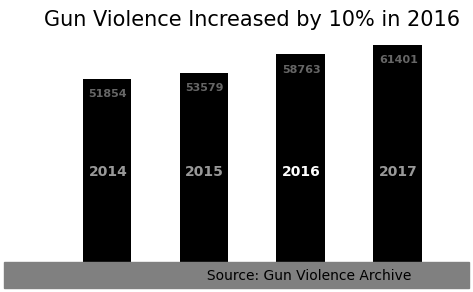

In [20]:
## create table for plot
annual = data_states.groupby(['year'])['incident_id'].count()
annual = pd.DataFrame(annual)

## percent growth year over year
annual_growth = annual['incident_id'].pct_change()*100

## plot
ax1 = annual.plot.bar(rot=30,color='black',figsize=(5,3))
plt.title('Gun Violence Increased by 10% in 2016',size=15)

## remove tick labels, legend, etc
plt.legend('',frameon=False)
plt.xlabel('')
plt.tick_params(left=False,labelleft=False,bottom=False,labelbottom=False)
ax1.axis('off')

##source bar
plt.text(-1,-4000,' '*45 + 'Source: Gun Violence Archive'+' '*12,color='black',fontsize=10,backgroundcolor='grey')

## place year labels
plt.text(-.19,25000,'2014',color='white',fontweight='bold',size=10,alpha=.6)
plt.text(1-.19,25000,'2015',color='white',fontweight='bold',size=10,alpha=.6)
plt.text(2-.19,25000,'2016',color='white',fontweight='bold',size=10)
plt.text(3-.19,25000,'2017',color='white',fontweight='bold',size=10,alpha=.6)

## place values
for i,v in enumerate(annual['incident_id']):
    plt.text(i-.19,v-5000,str(v),color='grey',fontweight='bold',size=8,alpha=.8)


plt.show()

In [21]:
annual_growth

year
2014         NaN
2015    3.326648
2016    9.675433
2017    4.489219
Name: incident_id, dtype: float64

It looks as though there was nearly a 10% jump in gun violence incidents in 2016. This stands out compared to other years' growth rates, although we would benefit from having more data. We should look at gun violence on a line chart accross all dates next to develop an understanding as to the timing of 2016 events.

### Incident Frequency by Date

To chart gun violence incidents by date, we first need to generate a frequency table. We will do this by supplying a dictionary with dates and counts via loop. Then, we will convert the dictionary to a dataframe and use the dataframe in a graph.

In [22]:
## loop through dataset to create incident frequency table by date

date_freq = {}

for date in data_states['date']:
    if date not in date_freq:
        date_freq[date]=1
    if date in date_freq:
        date_freq[date]+=1

## convert dictionary to table

date_freq_table = pd.DataFrame.from_dict(date_freq,orient='index')
date_freq_table = date_freq_table.reset_index()
date_freq_table = date_freq_table.rename(columns={'index':'date',0:'instances'})

## restrict 2016 data for chart

date_freq_2016 = date_freq_table[date_freq_table['date'].dt.year==2016]

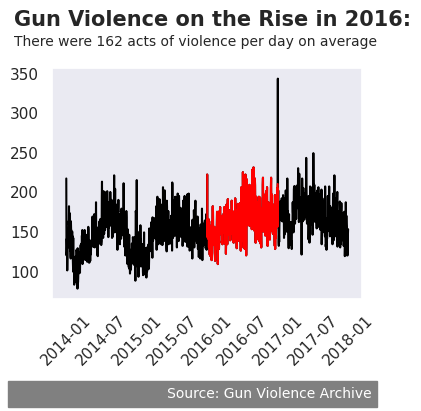

In [28]:
## graph table
ax2 = sns.lineplot(date_freq_table,x='date',y='instances',color='black')
ax3 = sns.lineplot(date_freq_2016,x='date',y='instances',color='red')

## set size
sns.set(rc={'figure.figsize':(4,3)})

## remove grid, add source box
ax2.grid(False)
plt.text(15800,-60,' '*35+'Source: Gun Violence Archive',color='white',fontsize=10,backgroundcolor='grey')

## remove/update labels
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45)

## title
plt.text(15800,410,'Gun Violence on the Rise in 2016:',size=15,weight='bold')
plt.text(15800,385,'There were 162 acts of violence per day on average',size=10)
plt.show()


* Despite two marked drops in 2014 and 2015, 2016 sees a consistent rise in gun violence with no drop in sight. 
* On average there are 162 counts of gun violence per day in 2016 vs 148 in 2015. That's a 9.5% increase in daily violence. 
* In 2017 there were 169 acts of gun violences per day on average, which is 4% more than 2016.
* Despite there being more gun violence events on average in 2017, we see that these events decrease over the course of the year.

In [24]:
print('2014:',date_freq_table[date_freq_table['date'].dt.year==2014]['instances'].mean())
print('2015:',date_freq_table[date_freq_table['date'].dt.year==2015]['instances'].mean())
print('2016:',date_freq_2016['instances'].mean())
print('2017:',date_freq_table[date_freq_table['date'].dt.year==2017]['instances'].mean())
print('Growth 2016:',(162-148)/148)
print('Growth 2017:',(169-162)/162)

2014: 143.06575342465754
2015: 148.19505494505495
2016: 161.9945205479452
2017: 169.68406593406593
Growth 2016: 0.0945945945945946
Growth 2017: 0.043209876543209874


## Conclusions

There was a marked increase in gun violence between 2015 and 2016 by approximately 10%, which supports our hypothesis that violence increased by at least 5% during the 2016 election year. While daily acts of violence verged on 144 and 148 per day on average in 2014 and 2015 respectively, these figures jumped in 2016 and 2017 to 161 and 169 events per day. Essentially, gun events starkly increased during the 2016 election year and into 2017.

We also learned that although some states have higher counts of both gun incidents and people affected by them, this does not necessarily increase the likelihood of fatality or injury. States with fewer events and people affected actually have a higher ratio of those affected per event, excluding Illinois. We were slightly relieved to see that not every event results in injury or fatality, as well.

Are we able to place blame on either President Obama or President Trump's administrations? No, but we can attest that violence did increase between the two administrations and note that violent acts peaked at the end of 2016 and the beginning of 2017 in our study of 2014-2017.